In [28]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"]="" 

# load model

In [30]:
model_dir ='/media/tohn/SSD/ModelTrainByImages/R1_3/models/B5_R1_AN_relu_1FC_fold3_3.h5' 
model = load_model(model_dir)
height = width = model.input_shape[1]

In [31]:
# validation
import pandas as pd
base_dir  = '/media/tohn/SSD/Images/Image3/'
dataframe = pd.read_csv( '/home/yupaporn/codes/USAI/Validationdf_fold3_3.csv') #fold1 set3, Validationdf_fold1_3.csv
validation_dir = os.path.join(base_dir, 'validation')

#Train
train_df = pd.read_csv( '/home/yupaporn/codes/USAI/Traindf_fold3_3.csv')
base_dir0 = '/media/tohn/SSD/Images/Image3/'
os.chdir(base_dir0)
train_dir = os.path.join(base_dir0, 'train')

# Select Data

In [32]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/Validationdf_fold3_3.csv')
print(df0 .shape)
dataframe = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
# a = df01[df01['Case'].between(1, 10)]
# dataframe = df01[df01['Abs Position']!='P8']
print(dataframe.shape)
print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)
dataframe.head(5)

(1032, 22)
(1032, 22)
Normal:  (559, 22)
Abnormal:  (473, 22)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,...,tagName,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight
0,0,54,54,22,P1,P1,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,MildFattyLiver,https://irisprodseatraining.blob.core.windows....,200.0,141.0,589.0,501.0,0.201802,0.156841,0.592793,0.557769
1,1,63,63,22,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,ModerateFattyLiver,https://irisprodseatraining.blob.core.windows....,155.0,67.0,506.0,639.0,0.166464,0.074874,0.543860,0.711111
2,2,65,65,22,P1,P1,Abnormal,AB03,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,SevereFattyLiver,https://irisprodseatraining.blob.core.windows....,287.0,132.0,432.0,694.0,0.292243,0.147601,0.439114,0.771717
3,3,71,71,22,P1,P1,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,Cirrhosis,https://irisprodseatraining.blob.core.windows....,178.0,125.0,652.0,450.0,0.176337,0.139520,0.643369,0.501010
4,4,73,73,22,P1,P1,Abnormal,AB05,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,PDF1,https://irisprodseatraining.blob.core.windows....,107.0,80.0,599.0,587.0,0.110607,0.089015,0.614525,0.652525


In [33]:
batch_size = 64
epochs = 10

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 1032 validated image filenames belonging to 2 classes.
{0: 'Abnormal', 1: 'Normal'}


# Prediction

In [34]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    val = -1
    idx = -1
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    pred_list.append(labels[np.argmax(predict_image(img_path[i]))])
    if np.argmax(predict_image(img_path[i])) == 0:
        prob_list.append(predict_image(img_path[i])[0])
    else:
        prob_list.append(predict_image(img_path[i])[1])
        
#     print(i)
#     print(np.argmax(predict_image(img_path[i])))

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

In [9]:
# dataframe.head(5)

# Visualization

In [35]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  2
{'Abnormal', 'Normal'}
Actual :  2
{'Normal', 'Abnormal'}


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Class'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 79.26356589147287%
              precision    recall  f1-score   support

    Abnormal       0.73      0.88      0.80       473
      Normal       0.87      0.72      0.79       559

    accuracy                           0.79      1032
   macro avg       0.80      0.80      0.79      1032
weighted avg       0.81      0.79      0.79      1032



### Confusion matrix

Text(0.5, 21.5, 'Predicted label')

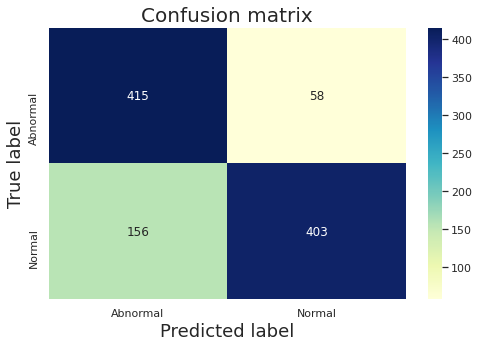

In [37]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

### ROC curve 

#### -  confusion_matrix function 

In [38]:
def confusion_matrix_all(data_train,threshold):

    #1. manage data  --------------------------------------------------------------------------------------------------------------------------------------------------

    p1 = data_train #Input table   
    act= p1['Class'].map({'Normal':0,'Abnormal':1}).values
    pred = p1['category'].map({'Normal':0,'Abnormal':1}).values

    import numpy as np
    n = len(p1)
    proplist = list()
    for i in range(0,n):
        score = p1.iloc[i].to_numpy()
        if score[22]=='Normal':
            prob = 1 - score[23]
            proplist.append(prob)
        else:
            prob = score[23]
            proplist.append(prob)


    prob_all =np.array(proplist)

#2. เงื่อนไข ---------------------------------------------------------------------------------------------------------------------------------------------
    
    import numpy as np
    from sklearn.metrics import confusion_matrix

    TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
    print(TN, FP, FN, TP)

# 3. threshold ----------------------------------------------------------------


    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    t = prob_all >= threshold
    #replace
    ts =t.tolist()
    alist =list()
    for i in range(0,len(ts)):
        if ts[i]==  True:
            a = 1
            alist.append(a)
        else:
            a = 0
            alist.append(a)

    tn, fp, fn, tp = confusion_matrix(act, alist).ravel()

    print('(TN,FP,FN,TP)')
    print('(',tn,',', fp,',', fn,',', tp,')')
    return tn, fp, fn, tp


In [39]:
#Test function
threshold = 0.5
confusion_matrix_all(data_train,threshold)

403 156 58 415
(TN,FP,FN,TP)
( 403 , 156 , 58 , 415 )


(403, 156, 58, 415)

#### -  run ROC curve

In [40]:
import numpy as np
threshold = np.arange(0.0, 1.002, 0.001)
precision, recall, ACC, TPR, FPR, SPEC = list(),list(),list(),list(),list(),list()
TN0, FP0, FN0, TP0 = list(),list(),list(),list()
for i in threshold:
    precision0, recall0, ACC0, TPR0, FPR0, SPEC0 = list(),list(),list(),list(),list(),list()
    
    tn,fp,fn,tp = confusion_matrix_all(data_train,i) 
    try:
        pre = tp/(tp+fp)
        re= tp/(tp+fn)
        acc = (tp+tn)/(tp+tn+fp+fn)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        spec = 1-(tn/(tn+fp))
    except ZeroDivisionError:
        pre,re,acc,tpr,fpr,spec =1,0,0,0,0,0      
            
    TP0.append(tp)
    TN0.append(tn)
    FP0.append(fp)
    FN0.append(fn)
    precision0.append(pre)
    recall0.append(re)
    ACC0.append(acc)
    TPR0.append(re)
    FPR0.append(fpr)       
    SPEC0.append(spec)
        
    precision.append(precision0)
    recall.append(recall0)
    ACC.append(ACC0)
    TPR.append(TPR0)
    FPR.append(FPR0)       
    SPEC.append(SPEC0)

403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 0 , 559 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 2 , 557 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 2 , 557 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 4 , 555 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 5 , 554 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 8 , 551 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 8 , 551 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 9 , 550 , 0 , 473 )
403 156 58 415
(TN,FP,FN,TP)
( 

403 156 58 415
(TN,FP,FN,TP)
( 114 , 445 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 116 , 443 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 117 , 442 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 118 , 441 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 118 , 441 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 118 , 441 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 119 , 440 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 124 , 435 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 125 , 434 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 125 , 434 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 126 , 433 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 128 , 431 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 128 , 431 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 129 , 430 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 130 , 429 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 130 , 429 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 131 , 428 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 134 , 425 , 3 , 470 )
403 156 58 415
(TN,FP,FN,TP)
( 134 , 425 , 3 ,

403 156 58 415
(TN,FP,FN,TP)
( 277 , 282 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 279 , 280 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 282 , 277 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 282 , 277 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 282 , 277 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 284 , 275 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 285 , 274 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 285 , 274 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 286 , 273 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 286 , 273 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 287 , 272 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 287 , 272 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 290 , 269 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 290 , 269 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 291 , 268 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 291 , 268 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 291 , 268 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 292 , 267 , 9 , 464 )
403 156 58 415
(TN,FP,FN,TP)
( 294 , 265 , 9 ,

403 156 58 415
(TN,FP,FN,TP)
( 392 , 167 , 38 , 435 )
403 156 58 415
(TN,FP,FN,TP)
( 394 , 165 , 38 , 435 )
403 156 58 415
(TN,FP,FN,TP)
( 395 , 164 , 38 , 435 )
403 156 58 415
(TN,FP,FN,TP)
( 395 , 164 , 38 , 435 )
403 156 58 415
(TN,FP,FN,TP)
( 395 , 164 , 38 , 435 )
403 156 58 415
(TN,FP,FN,TP)
( 396 , 163 , 42 , 431 )
403 156 58 415
(TN,FP,FN,TP)
( 396 , 163 , 42 , 431 )
403 156 58 415
(TN,FP,FN,TP)
( 396 , 163 , 42 , 431 )
403 156 58 415
(TN,FP,FN,TP)
( 396 , 163 , 42 , 431 )
403 156 58 415
(TN,FP,FN,TP)
( 397 , 162 , 44 , 429 )
403 156 58 415
(TN,FP,FN,TP)
( 397 , 162 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 397 , 162 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 397 , 162 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 397 , 162 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 398 , 161 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 398 , 161 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 398 , 161 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)
( 398 , 161 , 51 , 422 )
403 156 58 415
(TN,FP,FN,TP)

403 156 58 415
(TN,FP,FN,TP)
( 473 , 86 , 120 , 353 )
403 156 58 415
(TN,FP,FN,TP)
( 474 , 85 , 123 , 350 )
403 156 58 415
(TN,FP,FN,TP)
( 474 , 85 , 123 , 350 )
403 156 58 415
(TN,FP,FN,TP)
( 478 , 81 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 478 , 81 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 478 , 81 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 479 , 80 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 479 , 80 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 479 , 80 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 480 , 79 , 127 , 346 )
403 156 58 415
(TN,FP,FN,TP)
( 480 , 79 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 483 , 76 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 492 , 67 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 492 , 67 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 492 , 67 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 492 , 67 , 129 , 344 )
403 156 58 415
(TN,FP,FN,TP)
( 494 , 65 , 133 , 340 )
403 156 58 415
(TN,FP,FN,TP)
( 496 , 63 , 134 , 339 )
403 156 58 415
(TN,FP,FN,TP)

(TN,FP,FN,TP)
( 544 , 15 , 252 , 221 )
403 156 58 415
(TN,FP,FN,TP)
( 544 , 15 , 252 , 221 )
403 156 58 415
(TN,FP,FN,TP)
( 546 , 13 , 252 , 221 )
403 156 58 415
(TN,FP,FN,TP)
( 546 , 13 , 252 , 221 )
403 156 58 415
(TN,FP,FN,TP)
( 546 , 13 , 253 , 220 )
403 156 58 415
(TN,FP,FN,TP)
( 546 , 13 , 253 , 220 )
403 156 58 415
(TN,FP,FN,TP)
( 546 , 13 , 253 , 220 )
403 156 58 415
(TN,FP,FN,TP)
( 547 , 12 , 259 , 214 )
403 156 58 415
(TN,FP,FN,TP)
( 547 , 12 , 259 , 214 )
403 156 58 415
(TN,FP,FN,TP)
( 547 , 12 , 259 , 214 )
403 156 58 415
(TN,FP,FN,TP)
( 548 , 11 , 259 , 214 )
403 156 58 415
(TN,FP,FN,TP)
( 548 , 11 , 260 , 213 )
403 156 58 415
(TN,FP,FN,TP)
( 548 , 11 , 260 , 213 )
403 156 58 415
(TN,FP,FN,TP)
( 548 , 11 , 260 , 213 )
403 156 58 415
(TN,FP,FN,TP)
( 550 , 9 , 262 , 211 )
403 156 58 415
(TN,FP,FN,TP)
( 550 , 9 , 263 , 210 )
403 156 58 415
(TN,FP,FN,TP)
( 550 , 9 , 266 , 207 )
403 156 58 415
(TN,FP,FN,TP)
( 550 , 9 , 266 , 207 )
403 156 58 415
(TN,FP,FN,TP)
( 550 , 9 , 269 , 

403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 446 , 27 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 447 , 26 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 447 , 26 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 453 , 20 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 453 , 20 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 453 , 20 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 456 , 17 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 456 , 17 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 456 , 17 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 456 , 17 )
403 156 58 415
(TN,FP,FN,TP)
( 558 , 1 , 457 , 16 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 458 , 15 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 458 , 15 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 458 , 15 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 460 , 13 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 460 , 13 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 460 , 13 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 460 , 13 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 462 , 11 )
403 156 58 4

/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )
403 156 58 415
(TN,FP,FN,TP)
( 559 , 0 , 473 , 0 )


In [41]:
#average per threshold 
precision1,recall1,ACC1,TPR1,FPR1,SPEC1 = list(),list(),list(),list(),list(),list()
from statistics import *
for m in range(0,len(precision)):
    a1 =mean(precision[m])
    a2 =mean(recall[m])
    a3 =mean(ACC[m])
    a4 =mean(TPR[m])
    a5 =mean(FPR[m])
    a6 =mean(SPEC[m])
    
    precision1.append(a1)
    recall1.append(a2)
    ACC1.append(a3)
    TPR1.append(a4)
    FPR1.append(a5)       
    SPEC1.append(a6)   

In [42]:
#create dataframe
import numpy as np
i = np.arange(len(precision1)) # index for df
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision1, index = i),'Recall' : pd.Series(recall1, index = i),
                     'tpr' : pd.Series(TPR1, index = i),'fpr' : pd.Series(FPR1, index = i),'1-Spec' : pd.Series(SPEC1, index = i),  'ACC' : pd.Series(ACC1, index = i), 
                     'TN' : pd.Series(TN0, index = i), 'FP' : pd.Series(FP0, index = i), 'FN' : pd.Series(FN0, index = i), 'TP' : pd.Series(TP0, index = i)},)
roc0 = roc0.fillna(1)

In [43]:
roc0.head(10)

,Threshold,Precision,Recall,tpr,fpr,1-Spec,ACC,TN,FP,FN,TP
0,0.000,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
1,0.001,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
2,0.002,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
3,0.003,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
4,0.004,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
5,0.005,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
6,0.006,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
7,0.007,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
8,0.008,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473
9,0.009,0.458333,1.0,1.0,1.0,1.0,0.458333,0,559,0,473


#### -  sen VS spec

No handles with labels found to put in legend.


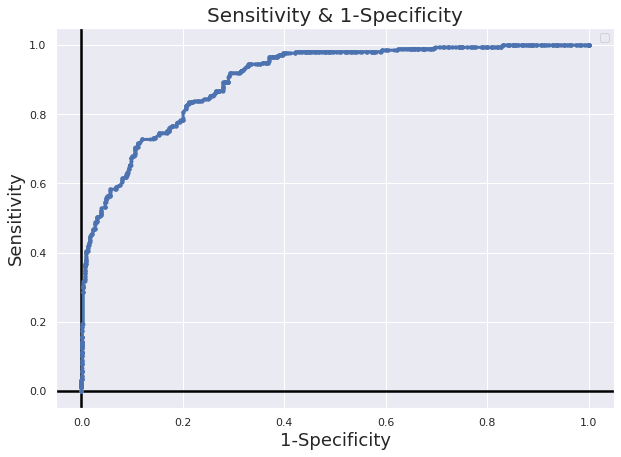

PR AUC (area = 0.90)


In [44]:
#sen VS spec
import numpy as np
import matplotlib.pyplot as plt
sen= np.array(roc0['tpr'])
spec = np.array(roc0['1-Spec'])
# from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
plt.plot([0, 0],[1, 1],'c', linestyle='--',lw=2.5)
plt.plot(spec,sen,'b', marker='.',lw=lw)  
    # axis labels
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.title('Sensitivity & 1-Specificity',fontsize=20)
    # show the legend
plt.legend()
    # show the plot
plt.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(spec, sen)
print('PR AUC (area = %0.2f)' % (auc_score))

#### -  Precision & Recall Curve

No handles with labels found to put in legend.


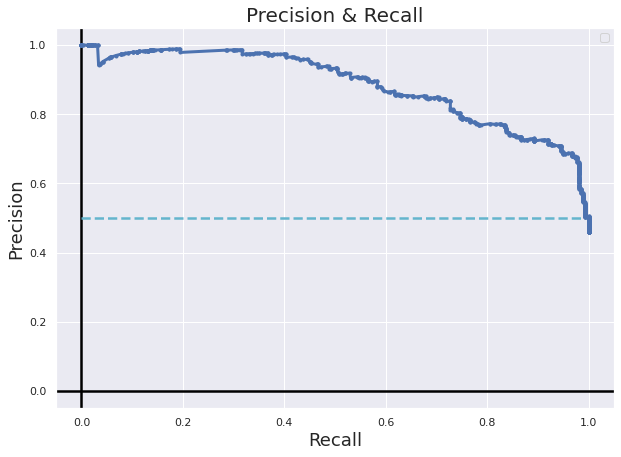

PR AUC (area = 0.88)


In [45]:
#Precision & Recall Curve
import numpy as np
recall = np.array(roc0['Recall'])
precision = np.array(roc0['Precision'])

import matplotlib.pyplot as plt
from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
fig.patch.set_facecolor('w')
plt.plot([0, 1], [0.5, 0.5],'c', linestyle='--',lw=2.5)
pyplot.plot(recall, precision,'b', marker='.', lw=lw)
    # axis labels
pyplot.xlabel('Recall',fontsize=18)
pyplot.ylabel('Precision',fontsize=18)
pyplot.title('Precision & Recall',fontsize=20)
    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print('PR AUC (area = %0.2f)' % (auc_score))

## Threshold 

In [20]:
#Select the best threshold
FN_min = roc0[roc0.FN == roc0.FN.min()]
FP_min = FN_min[FN_min.FP == FN_min.FP.min()]
FP_min

,Threshold,Precision,Recall,tpr,fpr,1-Spec,ACC,TN,FP,FN,TP
0,0.0,0.301685,1.0,1.0,1.0,1.0,0.301685,0,456,0,197


In [21]:
import numpy as np
# threshold = np.arange(0.0, 1.002, 0.001)
threshold = np.arange(0.0, 0.01, 0.00001)
precision, recall, ACC, TPR, FPR, SPEC = list(),list(),list(),list(),list(),list()
TN0, FP0, FN0, TP0 = list(),list(),list(),list()
for i in threshold:
    precision0, recall0, ACC0, TPR0, FPR0, SPEC0 = list(),list(),list(),list(),list(),list()
    
    tn,fp,fn,tp = confusion_matrix_all(data_train,i) 
    try:
        pre = tp/(tp+fp)
        re= tp/(tp+fn)
        acc = (tp+tn)/(tp+tn+fp+fn)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        spec = 1-(tn/(tn+fp))
    except ZeroDivisionError:
        pre,re,acc,tpr,fpr,spec =1,0,0,0,0,0      
            
    TP0.append(tp)
    TN0.append(tn)
    FP0.append(fp)
    FN0.append(fn)
    precision0.append(pre)
    recall0.append(re)
    ACC0.append(acc)
    TPR0.append(re)
    FPR0.append(fpr)       
    SPEC0.append(spec)
        
    precision.append(precision0)
    recall.append(recall0)
    ACC.append(ACC0)
    TPR.append(TPR0)
    FPR.append(FPR0)       
    SPEC.append(SPEC0)

410 46 25 172
(TN,FP,FN,TP)
( 0 , 456 , 0 , 197 )
410 46 25 172
(TN,FP,FN,TP)
( 285 , 171 , 0 , 197 )
410 46 25 172
(TN,FP,FN,TP)
( 290 , 166 , 2 , 195 )
410 46 25 172
(TN,FP,FN,TP)
( 296 , 160 , 2 , 195 )
410 46 25 172
(TN,FP,FN,TP)
( 301 , 155 , 2 , 195 )
410 46 25 172
(TN,FP,FN,TP)
( 304 , 152 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 308 , 148 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 312 , 144 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 315 , 141 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 315 , 141 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 316 , 140 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 316 , 140 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 318 , 138 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 319 , 137 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 321 , 135 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 323 , 133 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 325 , 131 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 327 , 129 , 3 , 194 )
410 46 25 172
(TN,FP,FN,TP)
( 328 , 128 , 3 , 194 )
410 46 25 172


410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 4 , 193 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 4 , 193 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 360 , 96 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 361 , 95 , 5 , 192 )
410 46 25 172
(TN,FP,FN,TP)
( 3

410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 369 , 87 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 370 , 86 , 6 , 191 )
410 46 25 172
(TN,FP,FN,TP)
( 3

410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 375 , 81 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 3

410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 8 , 189 )
410 46 25 172
(TN,FP,FN,TP)
( 3

410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 376 , 80 , 9 , 188 )
410 46 25 172
(TN,FP,FN,TP)
( 3

410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 172
(TN,FP,FN,TP)
( 377 , 79 , 10 , 187 )
410 46 25 17

In [22]:
#average per threshold 
precision1,recall1,ACC1,TPR1,FPR1,SPEC1 = list(),list(),list(),list(),list(),list()
from statistics import *
for m in range(0,len(precision)):
    a1 =mean(precision[m])
    a2 =mean(recall[m])
    a3 =mean(ACC[m])
    a4 =mean(TPR[m])
    a5 =mean(FPR[m])
    a6 =mean(SPEC[m])
    
    precision1.append(a1)
    recall1.append(a2)
    ACC1.append(a3)
    TPR1.append(a4)
    FPR1.append(a5)       
    SPEC1.append(a6)   

In [23]:
#create dataframe
import numpy as np
i = np.arange(len(precision1)) # index for df
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision1, index = i),'Recall' : pd.Series(recall1, index = i),
                     'tpr' : pd.Series(TPR1, index = i),'fpr' : pd.Series(FPR1, index = i),'1-Spec' : pd.Series(SPEC1, index = i),  'ACC' : pd.Series(ACC1, index = i), 
                     'TN' : pd.Series(TN0, index = i), 'FP' : pd.Series(FP0, index = i), 'FN' : pd.Series(FN0, index = i), 'TP' : pd.Series(TP0, index = i)},)
roc0 = roc0.fillna(1)

In [24]:
#Select the best threshold
FN_min = roc0[roc0.FN == roc0.FN.min()]
FP_min = FN_min[FN_min.FP == FN_min.FP.min()]
FP_min

,Threshold,Precision,Recall,tpr,fpr,1-Spec,ACC,TN,FP,FN,TP
1,0.00001,0.535326,1.0,1.0,0.375,0.375,0.738132,285,171,0,197


In [25]:
threshold = FP_min['Threshold'].tolist()[0]
threshold

1e-05

In [26]:


    #1. manage data  --------------------------------------------------------------------------------------------------------------------------------------------------

    p1 = data_train #Input table   
    act= p1['Class'].map({'Normal':0,'Abnormal':1}).values
    pred = p1['category'].map({'Normal':0,'Abnormal':1}).values

    import numpy as np
    n = len(p1)
    proplist = list()
    for i in range(0,n):
        score = p1.iloc[i].to_numpy()
        if score[10]=='Normal':
            prob = 1 - score[11]
            proplist.append(prob)
        else:
            prob = score[11]
            proplist.append(prob)


    prob_all =np.array(proplist)

#2. เงื่อนไข ---------------------------------------------------------------------------------------------------------------------------------------------
    
    import numpy as np
    from sklearn.metrics import confusion_matrix

    TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
    print(TN, FP, FN, TP)

# 3. threshold ----------------------------------------------------------------


    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    t = prob_all >= threshold
    #replace
    ts =t.tolist()
    alist =list()
    for i in range(0,len(ts)):
        if ts[i]==  True:
            a = 1
            alist.append(a)
        else:
            a = 0
            alist.append(a)

    tn, fp, fn, tp = confusion_matrix(act, alist).ravel()

    print('(TN,FP,FN,TP)')
    print('(',tn,',', fp,',', fn,',', tp,')')



410 46 25 172
(TN,FP,FN,TP)
( 285 , 171 , 0 , 197 )


In [27]:
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
print(classification_report(act, alist))#performance

              precision    recall  f1-score   support

           0       1.00      0.62      0.77       456
           1       0.54      1.00      0.70       197

    accuracy                           0.74       653
   macro avg       0.77      0.81      0.73       653
weighted avg       0.86      0.74      0.75       653



In [28]:
#replace
#0,1 -> Abnormal,Normal
pred_theshold =list()
for i in range(0,len(alist)):
    if alist[i]== 1:
        a = 'Abnormal'
        pred_theshold.append(a)
    else:
        a = 'Normal'
        pred_theshold.append(a)

In [29]:
#prob
import numpy as np
n = len(p1)
proplist = list()
for i in range(0,n):
    score = p1.iloc[i].to_numpy()
    if score[10]=='Normal':
        prob = 1 - score[11]
        proplist.append(prob)
    else:
        prob = score[11]
        proplist.append(prob)

prob_all =np.array(proplist)


resdf = list()
import numpy as np

act= p1['Class']
prob= p1['category']
path_= p1['Path Crop']
SubPosi= p1['Sub Position']

act = act.reset_index(drop=True)
prob = prob.reset_index(drop=True)
path_ = path_.reset_index(drop=True)
SubPosi = SubPosi.reset_index(drop=True)

for i in range(0,len(p1)):
    act_true = act[i]
    pred_max= pred_theshold[i]
    prob_new= prob[i]
    prob_old = prob_all[i]
    subposi = SubPosi[i]
    path = path_[i]
    
    resdf.append({'SubPosition':subposi,'Actual':act_true,'Predicted':pred_max, 'prob_new':prob_new, 'prob_old':prob_old, 'path':path})
res_df = pd.DataFrame(resdf)
res_df

,SubPosition,Actual,Predicted,prob_new,prob_old,path
0,P31,Abnormal,Abnormal,Abnormal,0.999988,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
1,P1,Abnormal,Abnormal,Abnormal,0.999967,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
2,P2,Abnormal,Abnormal,Abnormal,0.995860,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
3,P42,Abnormal,Abnormal,Abnormal,0.999966,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
4,P41,Abnormal,Abnormal,Abnormal,0.991718,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
...,...,...,...,...,...,...
648,P72,Normal,Abnormal,Normal,0.000031,/media/tohn/HDD/VISION_dataset/USAI/FPD JULY 2...
649,P72,Normal,Abnormal,Abnormal,0.903618,/media/tohn/HDD/VISION_dataset/USAI/FPD JULY 2...
650,P72,Normal,Abnormal,Abnormal,0.900133,/media/tohn/HDD/VISION_dataset/USAI/FPD JULY 2...
651,P72,Normal,Abnormal,Abnormal,0.999998,/media/tohn/HDD/VISION_dataset/USAI/FPD JULY 2...


In [30]:
data = {'Actual': act,'Predicted' : pred_theshold,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])
conf_mat

Predicted,Abnormal,Normal
Actual,,
Abnormal,197,0
Normal,171,285


Text(0.5, 21.5, 'Predicted label')

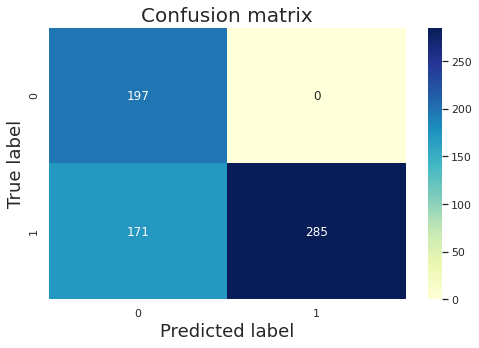

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred_theshold)

import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(cm , annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

# Grad CAM

### - create dataframe for Grad CAM 

In [ ]:
#สร้าง folder เก็บรูป 
import os
import shutil

path0 = "/media/tohn/SSD/image/test_GradCam/B0_val" 

try:
    os.mkdir(path0)
except OSError:
    shutil.rmtree(path0)
    os.mkdir(path0)

In [ ]:
#สร้าง folder เก็บรูป 
import os
import shutil

path1 = path0+'/abn_correct/'
path2 = path0+'/abn_missing/'
path3 = path0+'/Nor_correct/'
path4 = path0+'/Nor_missing/'
try:
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
    os.mkdir(path4)
except OSError:
    shutil.rmtree(path1)
    shutil.rmtree(path2)
    shutil.rmtree(path3)
    shutil.rmtree(path4)
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
    os.mkdir(path4)

### - Abnormal 

In [ ]:
#load image function
def load_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    return x,img

In [ ]:
df = dataframe
abnormal  = df[df['Class']=='Abnormal']
ab_correct = abnormal[abnormal['Class']==abnormal['category']] # correct
ab_wrong = abnormal[abnormal['Class']!=abnormal['category']]
#select position 
print('abnormal:',len(abnormal))
print('ab_correct:',len(ab_correct))
print('ab_wrong:',len(ab_wrong))
print(len(set(ab_correct['Sub Position'])))
print(set(ab_correct['Sub Position']))

####  ab_correct 

##### TF-explain 

In [ ]:
#### load only max &min prob of each views(P1,P2,P31,...,P72) *** For correct
max_df = list()
min_df = list()
classs = list(set(ab_correct['Sub Position']))
for i in classs:
    posi = ab_correct[ab_correct['Sub Position'] == i]
    #max
    max_prob = posi[posi['Prob'] == posi['Prob'].max()][0:1].reset_index()
    SubPosi = i
    case = 'ab_correct'
    case_prob = 'Max'
    prob = max_prob['Prob'].tolist()[0]
    path = max_prob['Path Crop'].tolist()[0]

    max_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
    
    #min
    min_prob = posi[posi['Prob'] == posi['Prob'].min()][0:1].reset_index()
    SubPosi = i
    case = 'ab_correct'
    case_prob = 'Min'
    prob = min_prob['Prob'].tolist()[0]
    path = min_prob['Path Crop'].tolist()[0]

    min_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
tabktdf = pd.DataFrame(max_df+min_df)
tabktdf

In [ ]:
img_paths = tabktdf['Path'].tolist()
case = tabktdf['Case_prob'].tolist()
prob = tabktdf['Prob'].round(4).tolist()
imlist = list()
idx = range(0,len(img_paths))
for i in idx :
    j = img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
    os.chdir(path1)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0)
    
    explainer.save(grid,'.',"ab_cor_"+str(i)+"_"+str(case[i])+"_"+str(prob[i])+"_"+str(j)+".png")
print(len(imlist))

##### Load USAI image 

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
# load the image
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path1)
    save_img(str(j)+'.png', img)
print(len(imlist))

####  ab_wrong

In [ ]:
print('nor_wrong:',len(ab_wrong))
w_img_paths = ab_wrong['Path Crop'].tolist()
w_prob = ab_wrong['Prob'].round(4).tolist()
ab_wrong.shape

In [ ]:
imlist = list()
idx = range(0,len(w_img_paths))
for i in idx :
    j = w_img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
#     print(j)
    os.chdir(path2)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(w_img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"Nor_missing_"+str(w_prob[i])+"_"+str(j)+"_"+str(i)+".png")
print(len(imlist))

#####  Load USAI image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path2)
    save_img(str(j)+'.png', img)
print(len(imlist))

#### *Show Correct Abnormal GradCam*

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread(img_paths[0])
plt.imshow(img)

#### *Show Miss Abnormal GradCam*

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(w_img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread(w_img_paths[0])
plt.imshow(img)

### Normal

In [ ]:
df = dataframe
normal  = df[df['Class']=='Normal']
nor_correct = normal[normal['Class']==normal['category']] # correct
nor_wrong = normal[normal['Class']!=normal['category']]
print('normal:',len(normal))
print('nor_correct:',len(nor_correct))
print('nor_wrong:',len(nor_wrong))
#select position 
print(len(set(nor_correct['Sub Position'])))
print(set(nor_correct['Sub Position']))

#### nor_correct 

##### TF-explain

In [ ]:
#### load only max &min prob of each views(P1,P2,P31,...,P72) *** For correct
max_df = list()
min_df = list()
classs = list(set(nor_correct['Sub Position']))
for i in classs:
    posi = nor_correct[nor_correct['Sub Position'] == i]
    #max
    max_prob = posi[posi['Prob'] == posi['Prob'].max()][0:1].reset_index()
    SubPosi = i
    case = 'nor_correct'
    case_prob = 'Max'
    prob = max_prob['Prob'].tolist()[0]
    path = max_prob['Path Crop'].tolist()[0]

    max_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
    
    #min
    min_prob = posi[posi['Prob'] == posi['Prob'].min()][0:1].reset_index()
    SubPosi = i
    case = 'nor_correct'
    case_prob = 'Min'
    prob = min_prob['Prob'].tolist()[0]
    path = min_prob['Path Crop'].tolist()[0]

    min_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
tabktdf = pd.DataFrame(max_df+min_df)
tabktdf

In [ ]:
#Load Grad Cam image

img_paths = tabktdf['Path'].tolist()
case = tabktdf['Case_prob'].tolist()
prob = tabktdf['Prob'].round(4).tolist()

imlist = list()
idx = range(0,len(img_paths))
for i in idx :
    j = img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
    os.chdir(path3)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"nor_cor_"+str(i)+"_"+str(case[i])+"_"+str(prob[i])+"_"+str(j)+".png")
print(len(imlist))

#####  Load USAI image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
# load the image
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path3)
    save_img(str(j)+'.png', img)
print(len(imlist))

#### Normal Miss

In [ ]:
print('nor_wrong:',len(nor_wrong))

In [ ]:
w_img_paths = nor_wrong['Path Crop'].tolist()
w_prob = nor_wrong['Prob'].round(4).tolist()
nor_wrong.shape

In [ ]:
imlist = list()
idx = range(0,len(w_img_paths))
for i in idx :
    j = w_img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
#     print(j)
    os.chdir(path4)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(w_img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"Nor_missing_"+str(w_prob[i])+"_"+str(j)+"_"+str(i)+".png")
print(len(imlist))

##### Load USAI image 

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path4)
    save_img(str(j)+'.png', img)
print(len(imlist))

##### *Show Correct NormalGradCam*

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

In [ ]:
img = mpimg.imread(img_paths[0])
plt.imshow(img)

##### *Show Miss Normal GradCam*

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(w_img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

In [ ]:
img = mpimg.imread(w_img_paths[0])
plt.imshow(img)